# Multivariate Linear Regression with Gradient Descent

In [ ]:
import numpy as np
from csv import reader
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data preprocessing
- Read data
- Normalize data
- Generate category features
- Split data to training set and testing set

In [ ]:
df = sns.load_dataset('tips')
print("First few data in the dataset:\n")
print(df.head())
print("Total features in the dataset:\n")
print(df.dtypes)
print(f"Number of unique days in the dataset: {df.day.nunique()}")
print(f"Number of unique time in the dataset: {df.time.nunique()}")
# df["smoker"] = df["smoker"].astype("category")


First few data in the dataset:

   total_bill   tip     sex smoker  day    time  size
0       16.99  1.01  Female     No  Sun  Dinner     2
1       10.34  1.66    Male     No  Sun  Dinner     3
2       21.01  3.50    Male     No  Sun  Dinner     3
3       23.68  3.31    Male     No  Sun  Dinner     2
4       24.59  3.61  Female     No  Sun  Dinner     4
Total features in the dataset:

total_bill     float64
tip            float64
sex           category
smoker        category
day           category
time          category
size             int64
dtype: object
Number of unique days in the dataset: 4
Number of unique time in the dataset: 2


### Feature vector
Here, we use one-hot encoding to encode categorical features. In addition, we define
$x = [$total_bill, size, sex, smoker, day, time$]^T \in R^{9\times1}$


In [ ]:
# Create category features with one-hot encoding
lb = LabelBinarizer()
ohe_day = lb.fit_transform(df.day)
ohe_sex = lb.fit_transform(df.sex)
ohe_smoker = lb.fit_transform(df.smoker)
ohe_time = lb.fit_transform(df.time)

In [ ]:
# Normalize data
total_bill = np.array((df.total_bill - df.total_bill.mean()) / df.total_bill.std()).reshape(-1, 1)
size = np.array((df['size'] - df['size'].mean()) / df['size'].std()).reshape(-1, 1)
X_T = np.column_stack((total_bill, size, ohe_sex, ohe_smoker, ohe_day, ohe_time))
Y = np.array((df.tip - df.tip.mean()) / df.tip.std()).reshape(-1, 1)

# Split the data
ratio = 0.2

X_T_train, X_T_test, Y_train, Y_test = train_test_split(X_T, Y, test_size=ratio, random_state=23)
print(X_T_train.shape)
print(X_T_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(195, 9)
(49, 9)
(195, 1)
(49, 1)


## Multivariate Linear Regression
The linear equation we are estimating is

\begin{equation}
y = w^Tx+b+\epsilon\\
\end{equation}

and the estimation would be
\begin{equation}
\hat{y}=w^Tx+b,\\
w = [w_1, w_2, ..., w_n]^T
\end{equation}
\
We will use gradient descent with the L2 loss function

\begin{equation}
L = \frac{1}{2N}\sum^N_i{(\hat{y}_i - y_i)^2} = \frac{1}{2N}\sum^N_i{(w^Tx_i - y_i)^2},\\
w \leftarrow w - \alpha \frac{\partial{L}}{\partial{w}},\\
b \leftarrow b - \alpha \frac{\partial{L}}{\partial{b}}
\end{equation}

where
\begin{equation}
\frac{\partial{L}}{\partial{w}} = \frac{1}{N} \sum^N_i (w^Tx_i - y_i)x_i = \frac{1}{N} \sum^N_i(\hat{y}_i - y_i)x_i\\
\frac{\partial{L}}{\partial{b}} = \frac{1}{N} \sum^N_i(\hat{y}_i - y_i)
\end{equation}
\
If we use stochastic gradient descent
\begin{equation}
L_i = \frac{1}{2}(\hat{y}_i - y_i)^2 = \frac{1}{2}(w^Tx_i - y_i)^2\\
w \leftarrow w - \alpha \frac{\partial{L_i}}{\partial{w}}\\
b \leftarrow b - \alpha \frac{\partial{L_i}}{\partial{b}}\\
\frac{\partial{L_i}}{\partial{w}} = (w^Tx_i - y_i)x_i = (\hat{y}_i - y_i)x_i\\
\frac{\partial{L_i}}{\partial{b}} = (\hat{y}_i - y_i)\\
\end{equation}
\
Since $w^Tx$ is a scalar, $w^Tx = x^Tw$. For computation coveniency, we will use $x^Tw$ in the implementation.
\
\
Moreover, if we want to implement Lasso regularization, for batch gradient descent,

\begin{equation}
L_{reg} = \frac{1}{2N}\sum^N_i{(\hat{y}_i - y_i)^2} + \lambda ||w||_1 \\
\frac{\partial{L_{reg}}}{\partial{w}} = \frac{1}{N} \sum^N_i(\hat{y}_i - y_i)x_i + \lambda\ sign(w)
\end{equation}

Simlarily for SGD

In [ ]:
class LinearRegression:
  def __init__(self):
    self.max_iter = 1000
    self.num_iter = 0
    self.converge_tol = 1e-5
    self.alpha = 1e-2
    self.loss = np.inf
    self.W = None
    self.b = None

  def fit(self, X_T, Y, L1_lambda=0, SGD=False, verbose=False):
    num_data, num_features = X_T.shape

    self.W = np.random.normal(0, 1, (num_features, 1))
    self.b = 0

    self.num_iter = 0
    prev_loss = None

    while self.num_iter < self.max_iter:
      if SGD:
        X_T_Y = np.column_stack((X_T, Y))
        np.random.shuffle(X_T_Y)
        self.loss = 0
        for x_T_y in X_T_Y:
          x_T = x_T_y[:-1].reshape(1, -1) # size: 1 X num_features
          y = x_T_y[-1]

          error = self.predict(x_T) - y # scalar
          self.loss += np.square(error) / num_data / 2.0
          dLdW = error * x_T.T  # Size: num_features X 1
          dLdb = error

          # Lasso regularization
          if L1_lambda != 0:
            self.loss += L1_lambda * np.linalg.norm(self.W, ord=1) / num_data
            dLdW += L1_lambda * np.sign(self.W) / num_data

          self.W -= self.alpha * dLdW
          self.b -= self.alpha * dLdb

      else:
        error = self.predict(X_T) - Y # Size: num_data X 1
        self.loss = np.sum(np.square(error)) / num_data / 2.0
        dLdW = np.sum(error * X_T, axis = 0).reshape(-1, 1) / num_data  # Size: num_features X 1
        dLdb = np.sum(error, axis = 0) / num_data

        # Lasso regularization
        if L1_lambda != 0:
          self.loss += L1_lambda * np.linalg.norm(self.W, ord=1)
          dLdW += L1_lambda * np.sign(self.W)

        self.W -= self.alpha * dLdW
        self.b -= self.alpha * dLdb

      if verbose and self.num_iter % 100 == 0:
        print("Loss: ", self.loss)
        print("W: ", self.W)
        print("b: ", self.b)

      if (prev_loss is not None and np.abs(self.loss - prev_loss) < self.converge_tol):
        print("Converge!")
        break
      else:
        prev_loss = self.loss

      self.num_iter += 1

  def predict(self, x_T):
    if self.W is None or self.b is None:
      print("Parameters are not fit yet")
      return None

    return x_T @ self.W + self.b

## Train the model

### Toy case
To test the code, we generate a simple toy case.

In [ ]:
w = 3
b = -0.7
num_data = 100

X_T_toy = np.random.rand(num_data, 1) * 10
Y_toy = X_T_toy * w + b + np.random.randn(num_data, 1)

Converge!
total iterations:
 629
loss:
 0.44355904489583686
W:
 [[2.94652959]]
b:
 [-0.29727888]


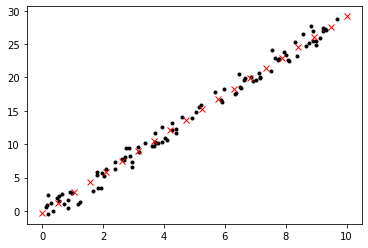

In [ ]:
# Batch GD
LR_GD = LinearRegression()
LR_GD.fit(X_T_toy, Y_toy)

print("total iterations:\n", LR_GD.num_iter)
print("loss:\n", LR_GD.loss)
print("W:\n", LR_GD.W)
print("b:\n", LR_GD.b)

figure, ax = plt.subplots()
ax.plot(X_T_toy.reshape(num_data), Y_toy.reshape(num_data), 'k.')
x_T_samples = np.linspace(0,10,20).reshape(-1, 1)
y_pred = LR_GD.predict(x_T_samples)
ax.plot(x_T_samples, y_pred, 'rx')

Converge!
total iterations:
 136
loss:
 [[0.51049738]]
W:
 [[3.12401248]]
b:
 [[-0.34511228]]


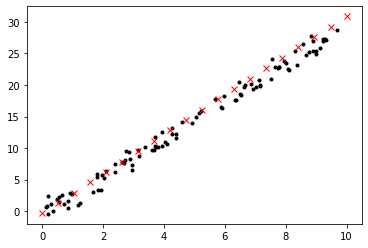

In [ ]:
# SGD
LR_SGD = LinearRegression()
LR_SGD.fit(X_T_toy, Y_toy, SGD=True)

print("total iterations:\n", LR_SGD.num_iter)
print("loss:\n", LR_SGD.loss)
print("W:\n", LR_SGD.W)
print("b:\n", LR_SGD.b)

figure, ax = plt.subplots()
ax.plot(X_T_toy.reshape(num_data), Y_toy.reshape(num_data), 'k.')
x_T_samples = np.linspace(0,10,20).reshape(-1, 1)
y_pred = LR_SGD.predict(x_T_samples)
ax.plot(x_T_samples, y_pred, 'rx')

[[2.96438396]]
[-0.41325372]


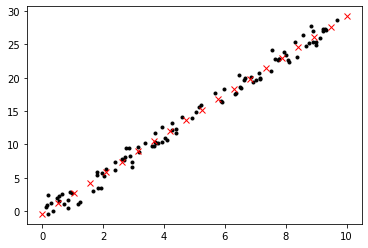

In [ ]:
# Compare with the linear regression model in sklearn
from sklearn import linear_model 
# Create linear regression model and assign it to the variable 'linModel'
linModel = linear_model.LinearRegression()
linModel.fit(X_T_toy, Y_toy)
print(linModel.coef_)
print(linModel.intercept_)

figure, ax = plt.subplots()
ax.plot(X_T_toy.reshape(num_data), Y_toy.reshape(num_data), 'k.')
x_T_samples = np.linspace(0,10,20).reshape(-1, 1)
y_pred = linModel.predict(x_T_samples)
ax.plot(x_T_samples, y_pred, 'rx')

### Train with real data

In [ ]:
# Batch gradient descent without lasso
LR_GD = LinearRegression()
LR_GD.fit(X_T_train, Y_train, verbose=False)

print("total iterations:\n", LR_GD.num_iter)
print("loss:\n", LR_GD.loss)
print("W:\n", LR_GD.W)
print("b:\n", LR_GD.b)

total iterations:
 1000
loss:
 0.2900153209702338
W:
 [[ 0.53499387]
 [ 0.14763661]
 [-0.23251114]
 [ 0.1106649 ]
 [ 0.21302133]
 [-0.07060753]
 [-0.01765906]
 [ 0.58210958]
 [-0.60522586]]
b:
 [0.1462711]


In [ ]:
# Batch gradient descent with lasso
LR_GD_lasso = LinearRegression()
LR_GD_lasso.fit(X_T_train, Y_train, L1_lambda=1e-2, verbose=False)

print("total iterations:\n", LR_GD_lasso.num_iter)
print("loss:\n", LR_GD_lasso.loss)
print("W:\n", LR_GD_lasso.W)
print("b:\n", LR_GD_lasso.b)

total iterations:
 1000
loss:
 0.2898968133146734
W:
 [[ 6.03010179e-01]
 [ 6.22896958e-02]
 [-6.23401390e-03]
 [-1.53053932e-01]
 [ 5.46246838e-02]
 [-9.83619596e-05]
 [-6.90062905e-02]
 [ 3.09716337e-02]
 [ 4.57909364e-05]]
b:
 [0.06920808]


In [ ]:
# Stochastic gradient descent
LR_SGD = LinearRegression()
LR_SGD.fit(X_T_train, Y_train, verbose=False)

print("total iterations:\n", LR_SGD.num_iter)
print("loss:\n", LR_SGD.loss)
print("W:\n", LR_SGD.W)
print("b:\n", LR_SGD.b)

Converge!
total iterations:
 818
loss:
 0.28075770985689386
W:
 [[ 0.61604082]
 [ 0.07451644]
 [ 0.02616443]
 [-0.13952943]
 [ 0.15971829]
 [ 0.1451767 ]
 [-0.01772461]
 [-0.00423802]
 [ 0.26120743]]
b:
 [-0.10903837]


In [ ]:
# Stochastic gradient descent with lasso
LR_SGD_lasso = LinearRegression()
LR_SGD_lasso.fit(X_T_train, Y_train, L1_lambda=5e-2, verbose=False)

print("total iterations:\n", LR_SGD_lasso.num_iter)
print("loss:\n", LR_SGD_lasso.loss)
print("W:\n", LR_SGD_lasso.W)
print("b:\n", LR_SGD_lasso.b)

Converge!
total iterations:
 651
loss:
 0.3160202529703474
W:
 [[ 5.47727397e-01]
 [ 6.24239896e-02]
 [-5.74812913e-02]
 [-2.45598101e-04]
 [-1.19447090e-03]
 [-2.61097989e-04]
 [-6.53747994e-04]
 [ 1.95946996e-04]
 [ 2.86511434e-04]]
b:
 [0.05971004]


In [ ]:
linModel = linear_model.LinearRegression()
linModel.fit(X_T_train, Y_train)
print(linModel.coef_)
print(linModel.intercept_)

[[ 0.58286756  0.1007737  -0.00181493 -0.04630166  0.0831398  -0.03916076
  -0.10674474  0.0627657  -0.01558751]]
[0.03373372]


## Test the model

In [ ]:
y_pred_GD = LR_GD.predict(X_T_test)
error_GD = np.sum(np.square(y_pred_GD - Y_test)) / len(y_pred_GD)
print(f"The error with batch gradient descent: {error_GD}")

y_pred_GD_lasso = LR_GD_lasso.predict(X_T_test)
error_GD_lasso = np.sum(np.square(y_pred_GD_lasso - Y_test)) / len(y_pred_GD_lasso)
print(f"The error with batch gradient descent and lasso regularizatoin: {error_GD_lasso}")

y_pred_SGD = LR_SGD.predict(X_T_test)
error_SGD = np.sum(np.square(y_pred_SGD - Y_test)) / len(y_pred_SGD)
print(f"The error with stochastic gradient descent: {error_SGD}")

y_pred_SGD_lasso = LR_SGD_lasso.predict(X_T_test)
error_SGD_lasso = np.sum(np.square(y_pred_SGD_lasso - Y_test)) / len(y_pred_SGD_lasso)
print(f"The error with stochastic gradient descent and lasso regularizatoin: {error_SGD_lasso}")

The error with batch gradient descent: 0.4642952944926491
The error with batch gradient descent and lasso regularizatoin: 0.4478979395065011
The error with stochastic gradient descent: 0.49343137253622854
The error with stochastic gradient descent and lasso regularizatoin: 0.45493483808130214


In [ ]:
y_pred_skl = linModel.predict(X_T_test)
error_skl = np.sum(np.square(y_pred_skl - Y_test)) / len(y_pred_skl)
print(f"The error with sklearn linear regression: {error_skl}")

The error with sklearn linear regression: 0.46017277997320266


## Conclusion
We can see that
- Batch gradient descent performs better than SGD, as the theory.
- With fine-tuned regularization rate, linear regression with Lasso performs better than without. This could indicate some features are redundant.